# Image classification using CNNs in Keras

## Context

Can you differentiate a weed from a crop seedling?

The ability to do so effectively can mean better crop yields and better stewardship of the environment.

The Aarhus University Signal Processing group, in collaboration with University of Southern Denmark, has recently 
released a dataset containing images of unique plants belonging to 12 species at several growth stages

## Objective

To implement the techniques learnt as a part of the course.

## Github Link


## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from google.colab import drive

import numpy as np
import pandas as pd
import itertools

import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.core.display import display, HTML

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Increase cell width
display(HTML("<style>.container { width:98% !important; }</style>"))

my_random_state = 5

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
print(tf.__version__)

2.3.0


In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


## Read Data

In [6]:
train_raw_images = np.load("/content/drive/My Drive/Colab Notebooks/PGP-AIML/datasets/projects/image_classification/images.npy")
train_raw_labels = pd.read_csv("/content/drive/My Drive/Colab Notebooks/PGP-AIML/datasets/projects/image_classification/Labels.csv")

In [7]:
print("")
print("Plant Seedlings Label Data")
print("**************************")
print("")
display(HTML(train_raw_labels.head(10).to_html()))


Plant Seedlings Label Data
**************************



In [8]:
print("")
print("Plant Seedlings Label -- Info")
print(train_raw_labels.info())


Plant Seedlings Label -- Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   4750 non-null   object
dtypes: object(1)
memory usage: 37.2+ KB
None


In [9]:
print("")
print("Plant Seedlings Label -- Null or Na")
print(train_raw_labels.isnull().any())
print(train_raw_labels.isna().any())


Plant Seedlings Label -- Null or Na
Label    False
dtype: bool
Label    False
dtype: bool


In [10]:
image_categories = train_raw_labels.Label.unique()
num_categories = len(image_categories)

In [11]:
num_categories

12

##### Observation
* Label data has **4750** entries
* There are **12** categories
* There are no null or missing values

## Shape of Data

### Shape of Images Dataset

In [12]:
train_raw_images.shape

(4750, 128, 128, 3)

### Shape of Labels Dataset

In [13]:
train_raw_labels.shape

(4750, 1)

##### Observation
* There are **4750** images in the dataset
* The image shapes are **128 x 128 x 3**
* These are RGB images
* The corresponding labels dataset has **4750** entries

## Visualize the images

### Value Counts

In [14]:
def image_grid(description, num_categories, labels, images_array):
    fig = plt.figure(figsize=(num_categories + 10, num_categories + 10))
    grid = ImageGrid(fig, 111, nrows_ncols=(num_categories, num_categories), axes_pad=0.05)
    image_index = 0
    i = 0
    prev_category = ""
    first_ax = None
    ax = None
    for category_id, category in enumerate(labels["Label"]):
        if category != prev_category:
            if i == num_categories:
                ax.text(140, 70, category, fontsize = 20, verticalalignment="center")
                prev_category = category
            else:
                ax = grid[image_index]
                ax.axis('off')
                ax.imshow(cv2.cvtColor(images_array[category_id], cv2.COLOR_BGR2RGB))
                image_index += 1
                i += 1
        else:
            i = 0
    fig.suptitle(description, fontsize = 20)
    fig.subplots_adjust(top=1)
    plt.show();

In [15]:
train_raw_labels.Label.value_counts()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
Name: Label, dtype: int64

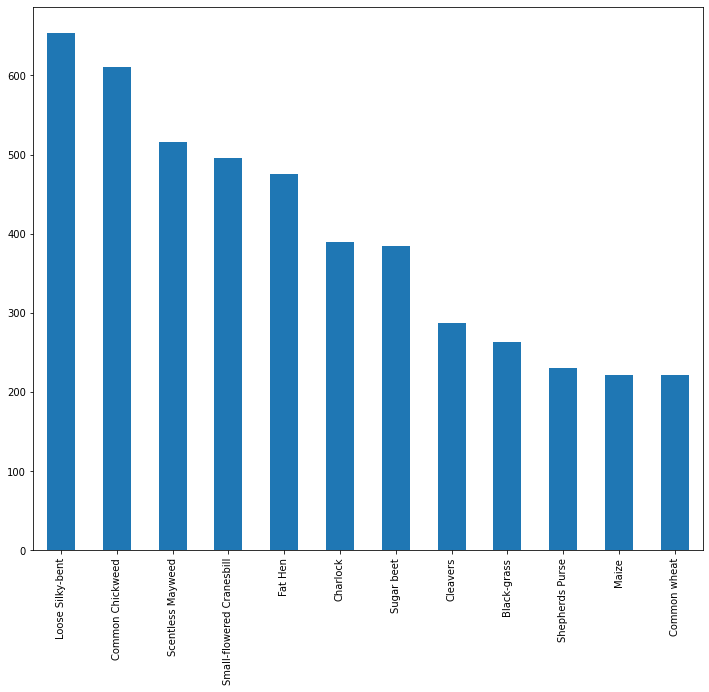

In [16]:
# Plot of label types numbers
train_raw_labels.Label.value_counts().plot(kind='bar')
plt.show();

##### Observation
* There are **12** classes in the dataset
* As we can see from the distribution, **Loose Silky-bent** and **Common Chickweed** have large distribution
* **Cleavers**, **Black-grass**, **Shepheres Purse**, **Maize** and **Common wheat** have lower distributions
* This shows that there is **class imbalance**

Lets take a look at the images of a sample number of plants

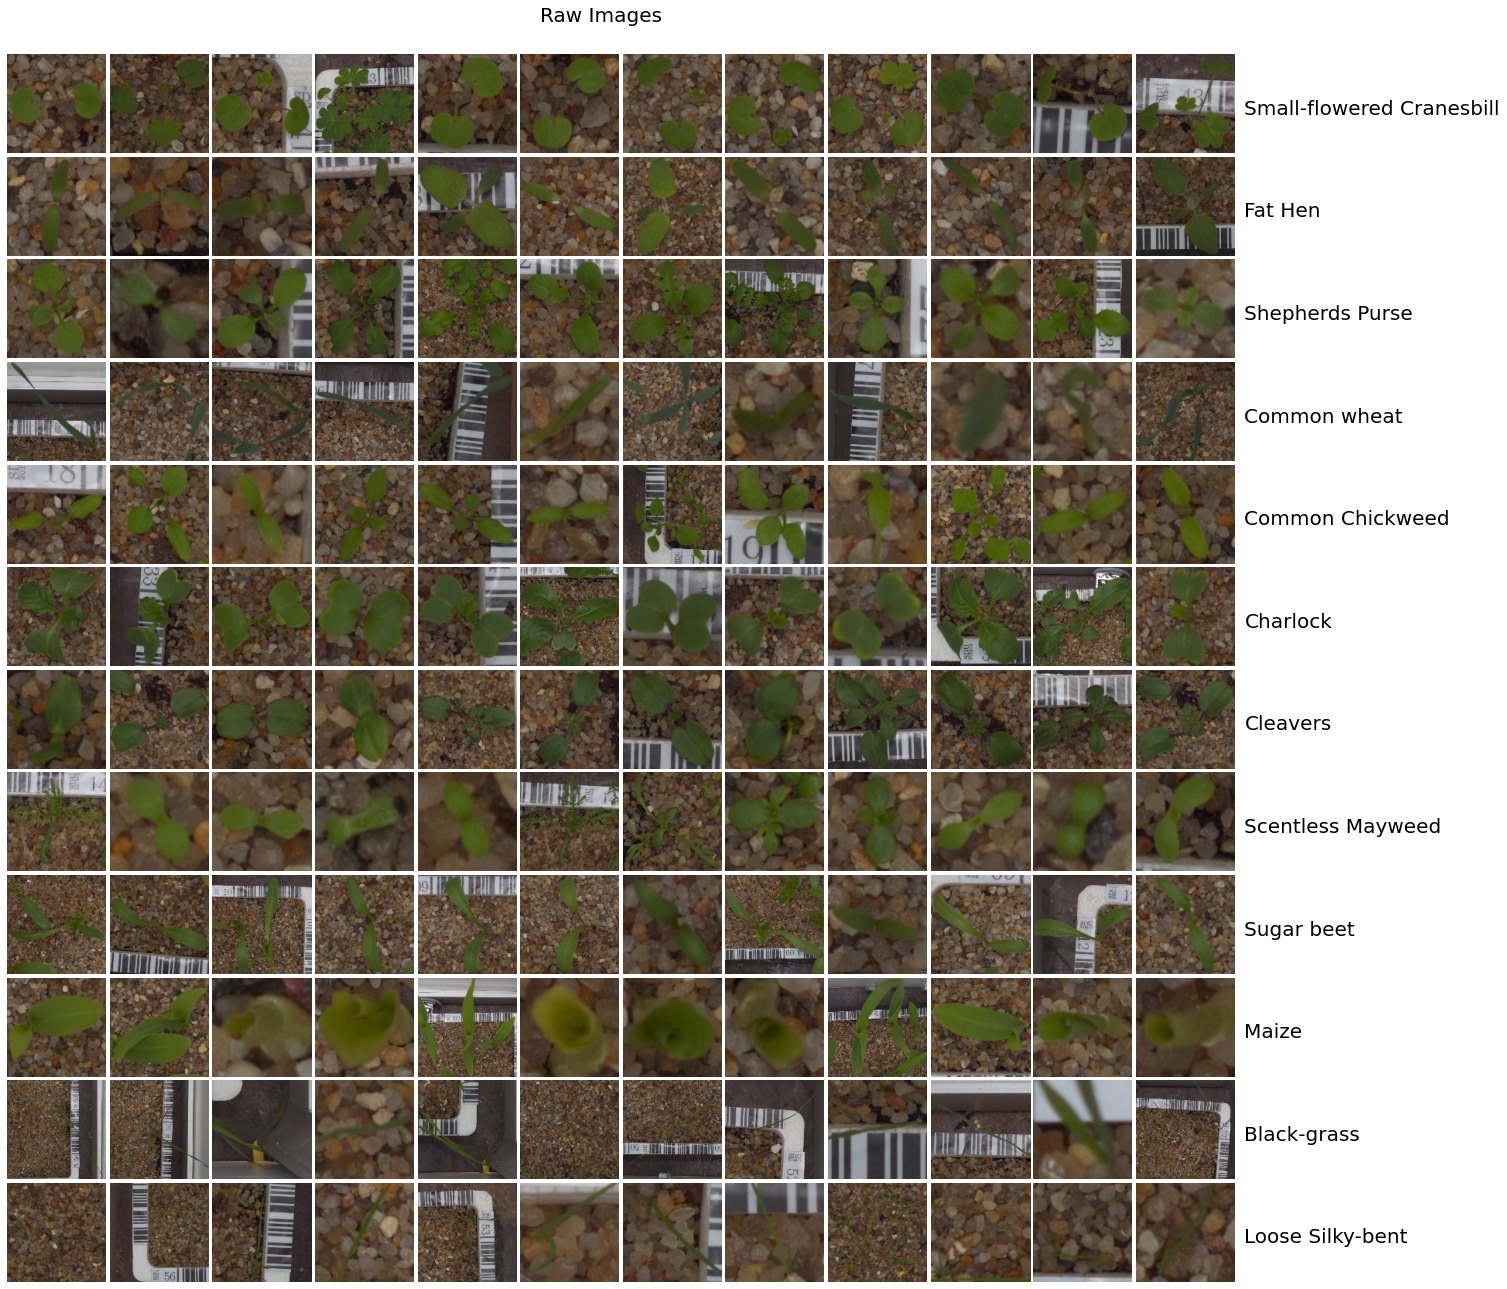

In [17]:
image_grid("Raw Images", num_categories, train_raw_labels, train_raw_images)

## Preprocess Data

### Normalize

Lets normalize the data. Since the pixels range in values from 0 to 255 for each channel (R, G & B), we can divide them by 255 (maximum value), to normalize the value between 0 and 1. 

In [18]:
train_images = train_raw_images.astype('float32')
train_images /= 255.0

train_labels = train_raw_labels.copy()

### Blur

As a next step, we can run a Gaussian Blur through the data, to reduce any effect of noise in the image and hence make it smoother.

In [19]:
X = train_images.copy()

In [20]:
for image_id, image_line in enumerate(X):
  X[image_id] = cv2.GaussianBlur(image_line, (5, 5), 0)

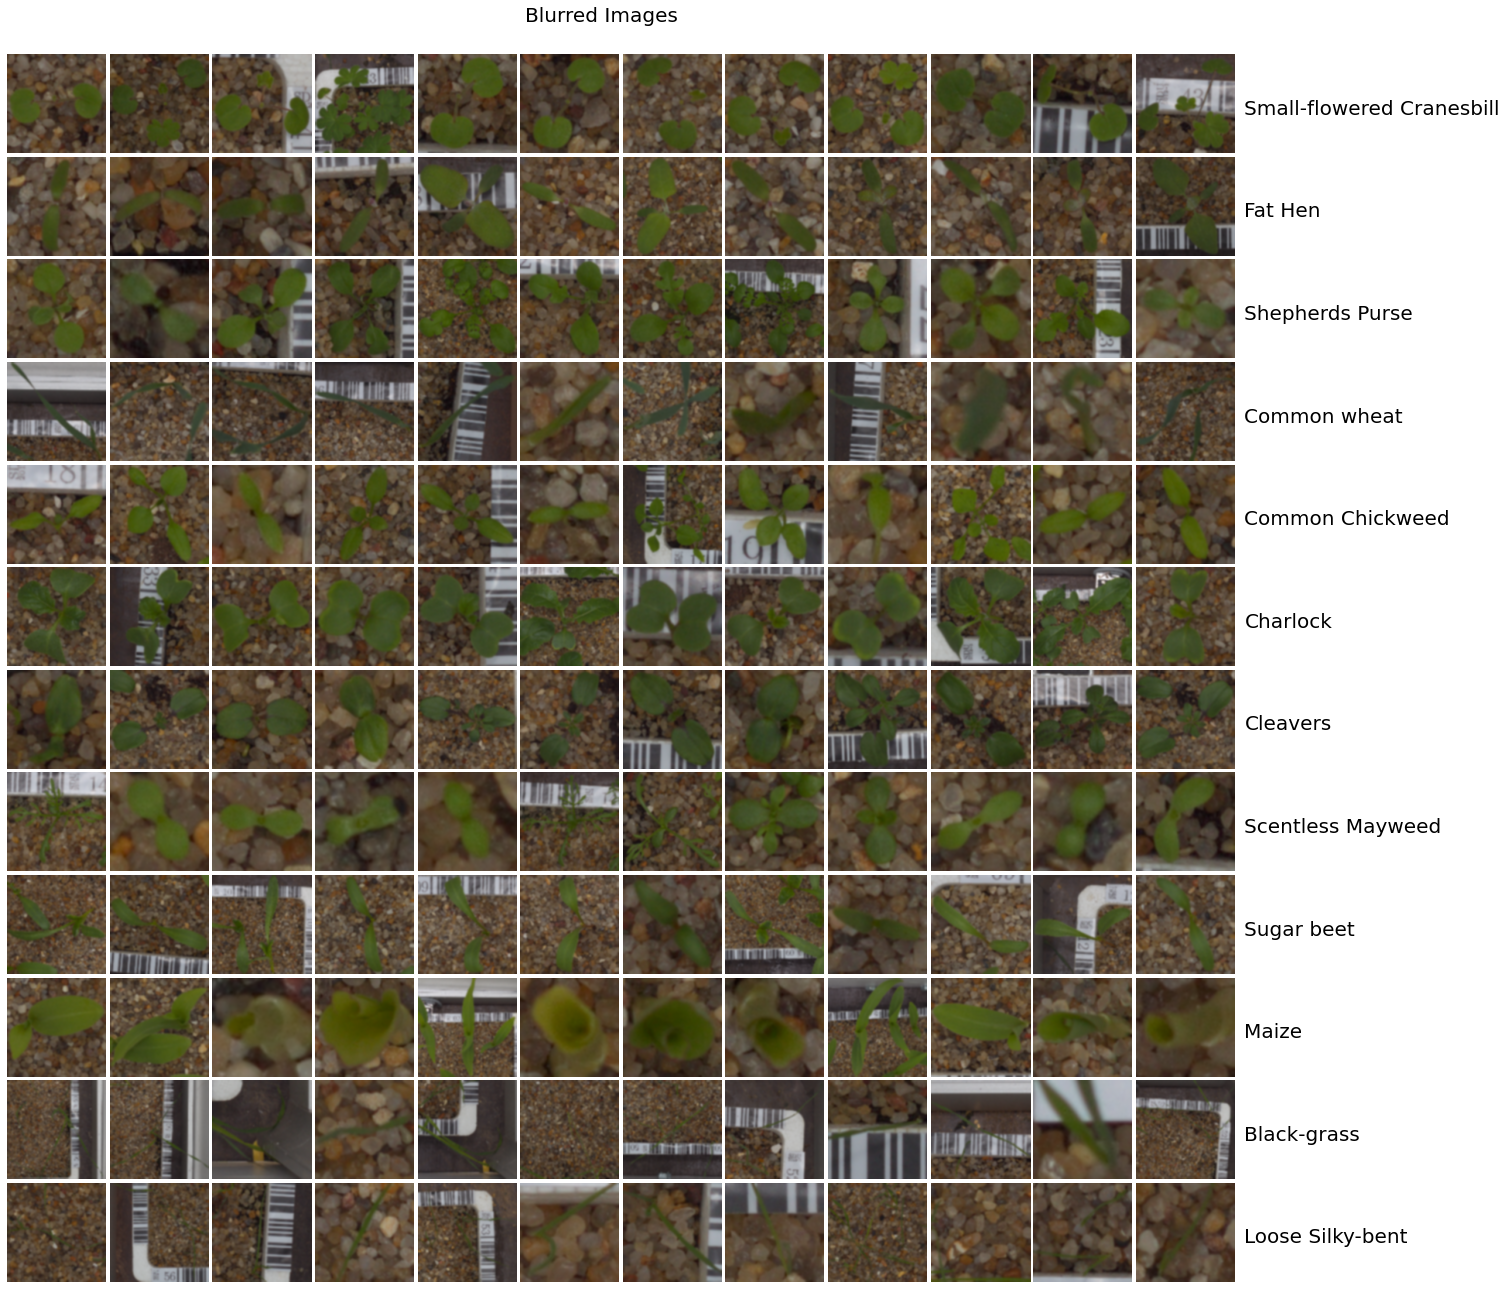

In [21]:
image_grid("Blurred Images", num_categories, train_labels, X)

### Visualize Data after preprocessing

Lets compare couple of images before and after the preprocessing

Index: 0 :: Label: Small-flowered Cranesbill


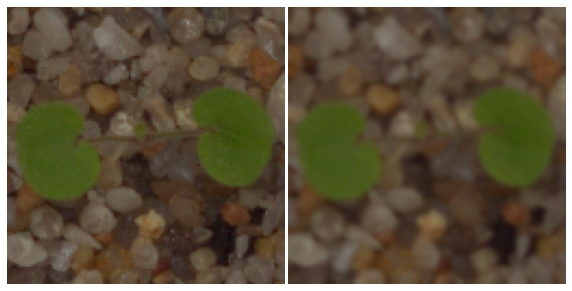



Index: 100 :: Label: Small-flowered Cranesbill


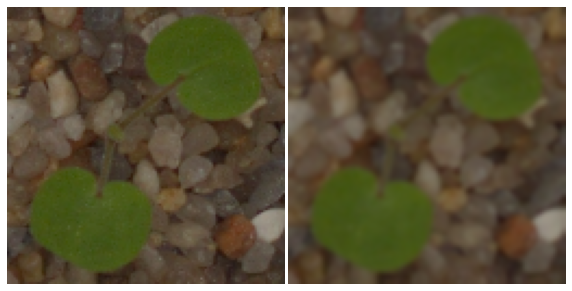



Index: 1000 :: Label: Shepherds Purse


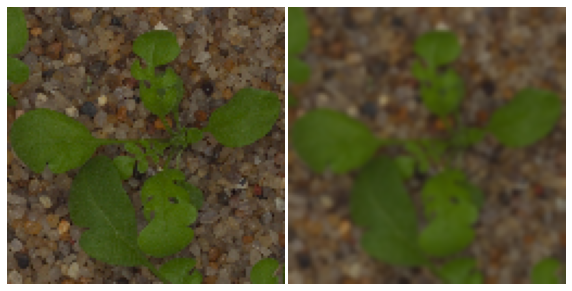



Index: 4000 :: Label: Black-grass


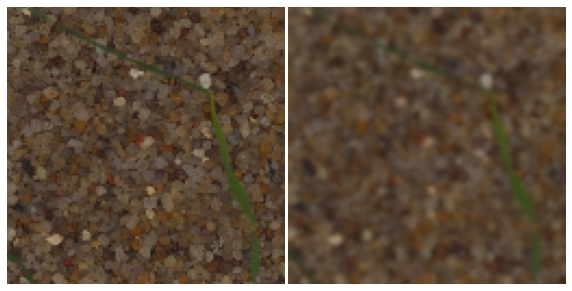

In [22]:
sample_index = [0, 100, 1000, 4000]
for idx, value in enumerate(sample_index):
    sample_index = value
    sample_label = train_labels.iloc[value].Label
    print("Index: {} :: Label: {}".format(sample_index, sample_label))
    fig = plt.figure(figsize=(10, 10))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.05)
    ax = grid[0]
    ax.axis('off')
    ax.imshow(cv2.cvtColor(train_raw_images[value], cv2.COLOR_BGR2RGB))
    ax = grid[1]
    ax.axis('off')
    ax.imshow(cv2.cvtColor(X[value], cv2.COLOR_BGR2RGB))
    plt.show();
    print("")
    print("")

## Prepare Data

### Encode Labels

Lets convert the class labels to encoded labels (numeric) and then convert them to binary class matrices

In [23]:
# Encode labels and create classes
le = LabelEncoder()
le.fit(train_labels.Label)
print("Classes: " + str(le.classes_))
train_encode_labels = le.transform(train_labels.Label)


# Make labels categorical
y = to_categorical(train_encode_labels)
num_clases = y.shape[1]
print("Number of classes: " + str(num_clases))

Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
Number of classes: 12


In [24]:
print("After encoding, the labels look like")
print(y)

After encoding, the labels look like
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Print the label for y_train[0] 

In [25]:
train_labels.iloc[0]

Label    Small-flowered Cranesbill
Name: 0, dtype: object

In [26]:
print(y[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [27]:
print(y.shape)

(4750, 12)


### Split the data

Lets split the data set into Train and Test sets with 30% allocated to testing.
<br>Of the 30% allocated for Testing, lets further split it into Testing and Validation sets with 50% allocated for Testing and Validation

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=my_random_state)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=my_random_state)

### Shape of data

In [29]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print("")
print('X_valid shape:', X_valid.shape)
print('y_valid shape:', y_valid.shape)
print("")
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print("")

X_train shape: (3325, 128, 128, 3)
y_train shape: (3325, 12)

X_valid shape: (713, 128, 128, 3)
y_valid shape: (713, 12)

X_test shape: (712, 128, 128, 3)
y_test shape: (712, 12)



The shape of the data is compatible with Keras. No reshaping is required

## Building CNN

### Define Layers

In [30]:
# Set the random state
tf.random.set_seed(my_random_state)

model = Sequential()

# By adding BatchNormlization and also with a lower dropout rate, lower test performance was observed. 
# So instead removed those changes and tried the basic as discussed in mentor session

# Add a convolution layer of 32 3X3 filters, with relu activation, with padding
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation="relu", input_shape=X_train.shape[1:]))

# Add a convolution layer of 32 3X3 filters, with relu activation
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu"))

# Add a max pooling layer of size 2X2
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a dropout of 25% 
model.add(Dropout(rate=0.25))

# Add a convolution layer of 64 3X3 filters, with relu activation, with padding
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))

# Add a convolution layer of 64 3X3 filters, with relu activation
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

# Add a max pooling layer of size 2X2
model.add(MaxPooling2D((2, 2)))

# Add a dropout of 25% 
model.add(Dropout(0.25))

# Flatten the layer
model.add(Flatten())

# Add Fully Connected Layer with 512 units and activation function as 'relu'
model.add(Dense(512, activation='relu'))

# Add a dropout of 50% 
model.add(Dropout(0.5))

#Add Fully Connected Layer with 12 units and activation function as 'softmax'
model.add(Dense(12, activation="softmax"))

### Optimizer and Loss function

In [31]:
# initiate Adam optimizer
opt = keras.optimizers.Adam(learning_rate=0.0001)

In [32]:
# Compile the model
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=opt)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [33]:
#Adding Early stopping callback to the fit function is going to stop the training,
#if the val_loss is not going to change even '0.001' for more than 10 continous epochs
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)


#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training
model_checkpoint =  ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/PGP-AIML/datasets/projects/image_classification/plant_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)

In [34]:
# Fit the model
model_history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=30, validation_data=(X_valid, y_valid), shuffle=True, callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
104/104 [==============================] - ETA: 0s - loss: 2.3836 - accuracy: 0.1786
Epoch 00001: val_loss improved from inf to 2.14340, saving model to /content/drive/My Drive/Colab Notebooks/PGP-AIML/datasets/projects/image_classification/plant_cnn_checkpoint_01_loss2.1434.h5
104/104 [==============================] - 5s 50ms/step - loss: 2.3836 - accuracy: 0.1786 - val_loss: 2.1434 - val_accuracy: 0.3338
Epoch 2/30
103/104 [============================>.] - ETA: 0s - loss: 1.8807 - accuracy: 0.3623
Epoch 00002: val_loss improved from 2.14340 to 1.65734, saving model to /content/drive/My Drive/Colab Notebooks/PGP-AIML/datasets/projects/image_classification/plant_cnn_checkpoint_02_loss1.6573.h5
104/104 [==============================] - 5s 45ms/step - loss: 1.8797 - accuracy: 0.3627 - val_loss: 1.6573 - val_accuracy: 0.4516
Epoch 3/30
103/104 [============================>.] - ETA: 0s - loss: 1.6062 - accuracy: 0.4417
Epoch 00003: val_loss improved from 1.65734 to 1.48695, 

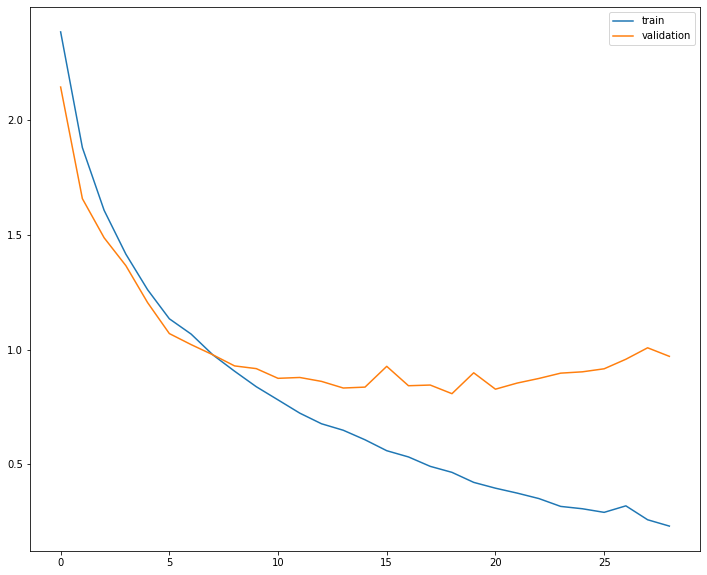

In [35]:
# plot training history
plt.plot(model_history.history['loss'], label='train')
plt.plot(model_history.history['val_loss'], label='validation')
plt.legend()
plt.show()

## Evaluate the model

In [36]:
train_score = model.evaluate(X_train, y_train)
print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])

104/104 [==============================] - 1s 12ms/step - loss: 0.0807 - accuracy: 0.9865
Train loss: 0.08068661391735077
Train accuracy: 0.9864661693572998


In [38]:
test_score = model.evaluate(X_test, y_test)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

23/23 [==============================] - 0s 13ms/step - loss: 0.8875 - accuracy: 0.7612
Test loss: 0.887482225894928
Test accuracy: 0.7612359523773193


### Confusion Matrix

In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [44]:
# Predict for the test cases
y_pred = model.predict(X_test)

# Softmax would give probabilities. Find the max probability to identify the class for the prediction
y_pred_classes = np.argmax(y_pred, axis = 1)

# Identify the class for the prediction for the test cases
y_true = np.argmax(y_test, axis = 1) 

In [45]:
# confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes) 

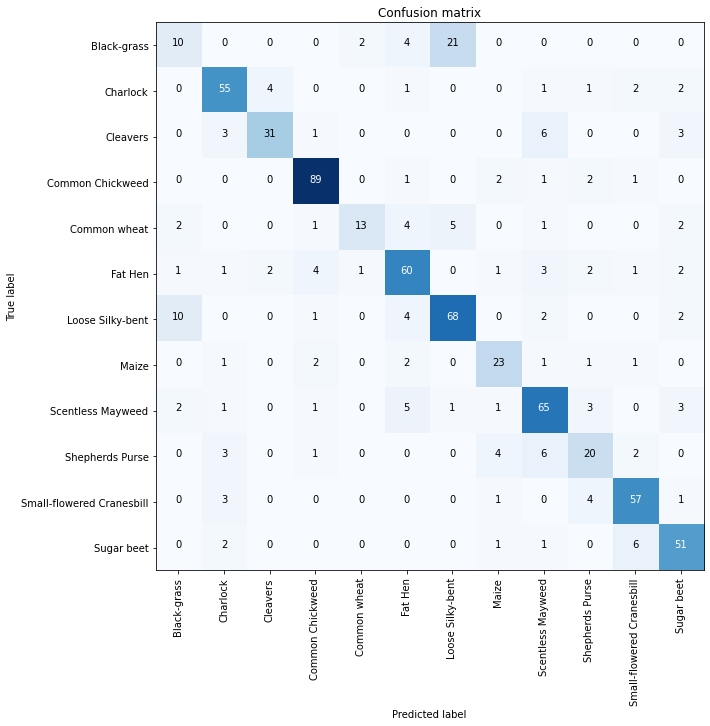

In [46]:
# plot the confusion matrix
plot_confusion_matrix(conf_matrix, classes = le.classes_) 

## Visualize Prediction

Lets visualize some sample predictions

In [47]:
def visualize_prediction(model, raw, X, y, index, classes):
    plt.axis('off')
    plt.imshow(cv2.cvtColor(raw[index], cv2.COLOR_BGR2RGB))
    y_pred = model.predict(X[index].reshape(1, 128, 128, 3))
    actual_index = np.argmax(y[index])
    print("Actual Label:{} ({})".format(classes[actual_index], actual_index))
    print("Predicted label:{} ({})".format(classes[y_pred.argmax()], y_pred.argmax()))
    plt.show();

Actual Label:Fat Hen (5)
Predicted label:Fat Hen (5)


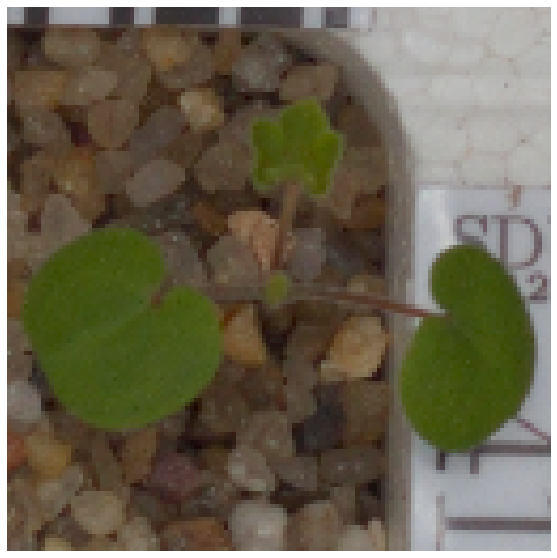

In [48]:
visualize_prediction(model, train_raw_images, X_test, y_test, 2, le.classes_)

Actual Label:Sugar beet (11)
Predicted label:Sugar beet (11)


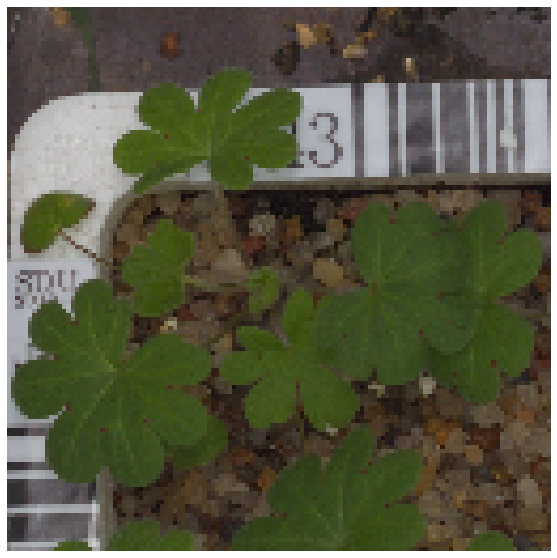

In [49]:
visualize_prediction(model, train_raw_images, X_test, y_test, 3, le.classes_)

Actual Label:Small-flowered Cranesbill (10)
Predicted label:Small-flowered Cranesbill (10)


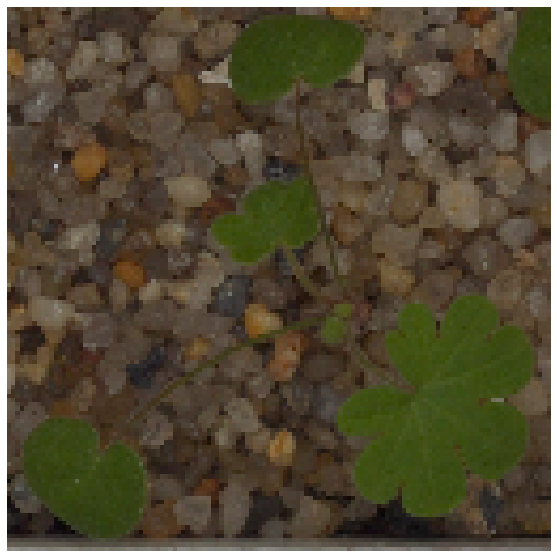

In [50]:
visualize_prediction(model, train_raw_images, X_test, y_test, 33, le.classes_)

Actual Label:Common Chickweed (3)
Predicted label:Common Chickweed (3)


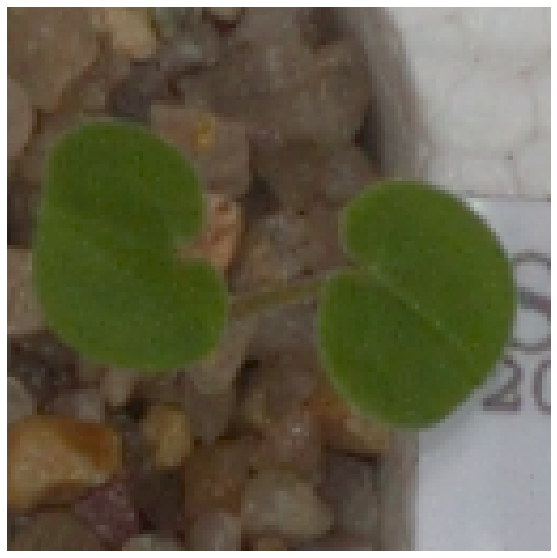

In [51]:
visualize_prediction(model, train_raw_images, X_test, y_test, 36, le.classes_)

Actual Label:Scentless Mayweed (8)
Predicted label:Scentless Mayweed (8)


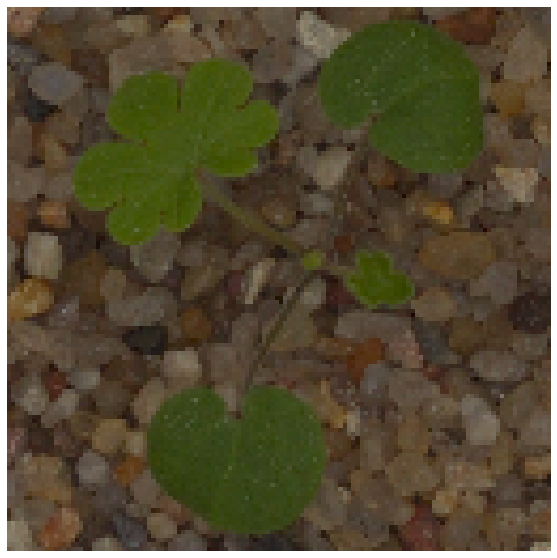

In [52]:
visualize_prediction(model, train_raw_images, X_test, y_test, 59, le.classes_)

## Conclusion
* As we can see, with the basic transformation of the image, we were able to get **76%** accuracy with the test data
* However in order to improve this, we can try
    * Detecting the actual plant edges in the image and remove the rest, like background
    * Try varying degrees of the Gaussian Filters
    * Try changing the number of neurons in the Conv layer
    * Try adding more layers
* But with the expectation from this project, the result we have is acceptable and we can effectively identify plant species